In [1]:
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
from torchinfo import summary
from torch import nn, accelerator
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def set_seed(seed: int = 123):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

set_seed()

device = accelerator.current_accelerator() if accelerator.is_available() else torch.device('cpu')
print(f"Device: {device}")

Device: cuda


In [2]:
dir_path = Path('/kaggle/input/fer2013')
train_dir = dir_path / 'train'
test_dir = dir_path / 'test'
# for dirpath, dirnames, filenames in os.walk(dir_path):
#     print(f"Dirs: {len(dirnames)} | Imgs: {len(filenames)} | Paths: {dirpath}")

In [3]:
train_img_path_list = list(train_dir.glob("*/*.jpg"))
train_labels = [p.parent.stem for p in train_img_path_list]

test_path = list(test_dir.glob("*/*.jpg"))
test_labels = [p.parent.stem for p in list(test_dir.glob("*/*.jpg"))]

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_img_path_list, train_labels, test_size=0.2, random_state=123, stratify=train_labels
)

print(f"Full train path size : {len(train_img_path_list)} | Full train label size : {len(train_labels)}\n"
      f"Train data: {len(train_paths)} | Labels: {len(train_labels)}\n"
      f"Val data: {len(val_paths)} | Labels: {len(val_labels)}")

Full train path size : 28709 | Full train label size : 22967
Train data: 22967 | Labels: 22967
Val data: 5742 | Labels: 5742


Original Training Distribution:


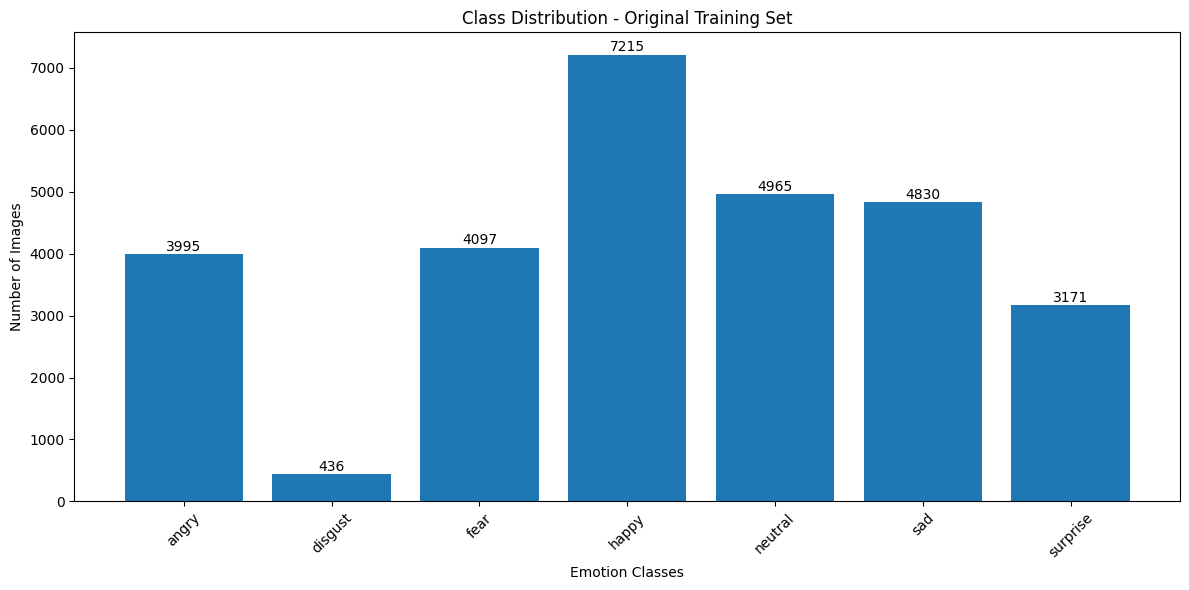


Original Test Distribution:


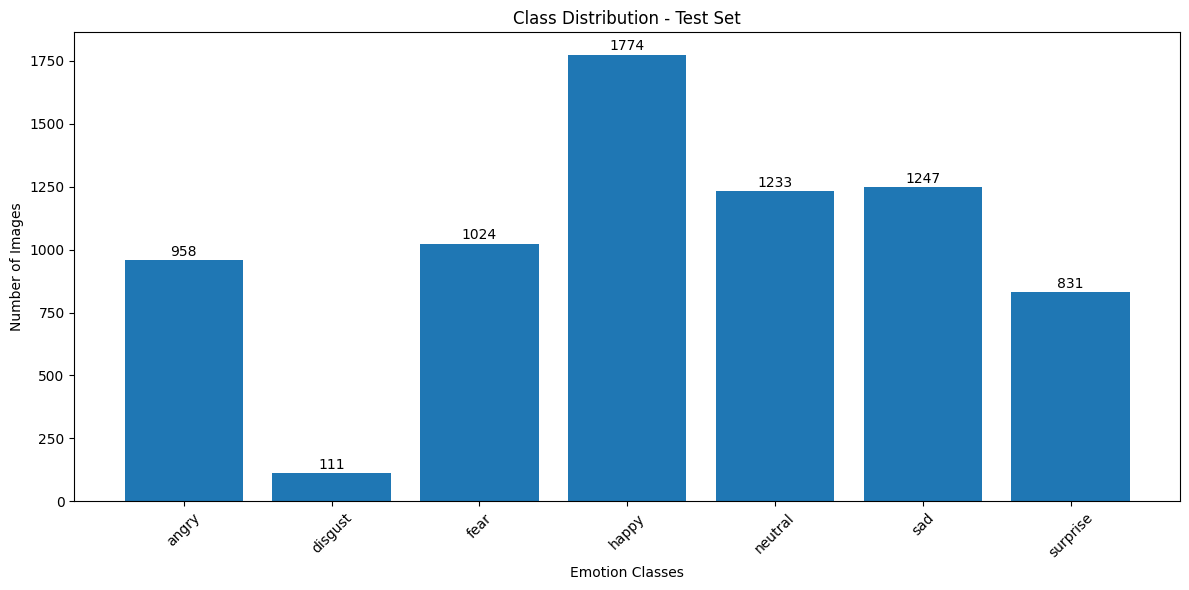


=== SUMMARY ===
Total training images: 28709
Total test images: 7178

Class counts (Train / Test):
angry: 3995 / 958
disgust: 436 / 111
fear: 4097 / 1024
happy: 7215 / 1774
neutral: 4965 / 1233
sad: 4830 / 1247
surprise: 3171 / 831


In [4]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(data_dir, title):
    """
    Plot class distribution from directory structure
    """
    class_counts = {}
    class_names = sorted([d.name for d in data_dir.iterdir() if d.is_dir()])
    
    for class_name in class_names:
        class_dir = data_dir / class_name
        class_counts[class_name] = len(list(class_dir.glob('*.*')))  # Count all files
    
    # Plotting
    plt.figure(figsize=(12, 6))
    bars = plt.bar(class_counts.keys(), class_counts.values())
    plt.title(f'Class Distribution - {title}')
    plt.xlabel('Emotion Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    
    # Add count labels on bars
    for bar, count in zip(bars, class_counts.values()):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                str(count), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return class_counts

# Plot original distributions
print("Original Training Distribution:")
train_counts = plot_class_distribution(train_dir, 'Original Training Set')

print("\nOriginal Test Distribution:")
test_counts = plot_class_distribution(test_dir, 'Test Set')

# Print summary
print("\n=== SUMMARY ===")
print(f"Total training images: {sum(train_counts.values())}")
print(f"Total test images: {sum(test_counts.values())}")
print("\nClass counts (Train / Test):")
for cls in train_counts:
    print(f"{cls}: {train_counts[cls]} / {test_counts.get(cls, 0)}")

In [5]:
# Do visualization on one Image to see the image shape
# rand_img = random.choice(train_img_path_list)
# img_class = rand_img.parent.stem
# img = Image.open(rand_img)

# print(f"Path: {rand_img}\nImg class: {img_class}\nImg size: {img.size}")
# img

In [6]:
class FERDataset(Dataset):
    def __init__(self, paths, classes, transform=None):
        self.paths = paths
        self.classes = classes
        self.transform = transform
        self.class_to_idx = {cls: i for i, cls in enumerate(sorted(set(classes)))}

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = Image.open(img_path)
        class_idx = self.class_to_idx[self.classes[idx]]

        if self.transform:
            img = self.transform(img)

        return img, class_idx

base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = FERDataset(train_paths, train_labels, train_transform)
val_dataset = FERDataset(val_paths, val_labels, base_transform)
test_dataset = FERDataset(test_path, test_labels, base_transform)
CLASS_NAMES = sorted(set(train_dataset.classes))

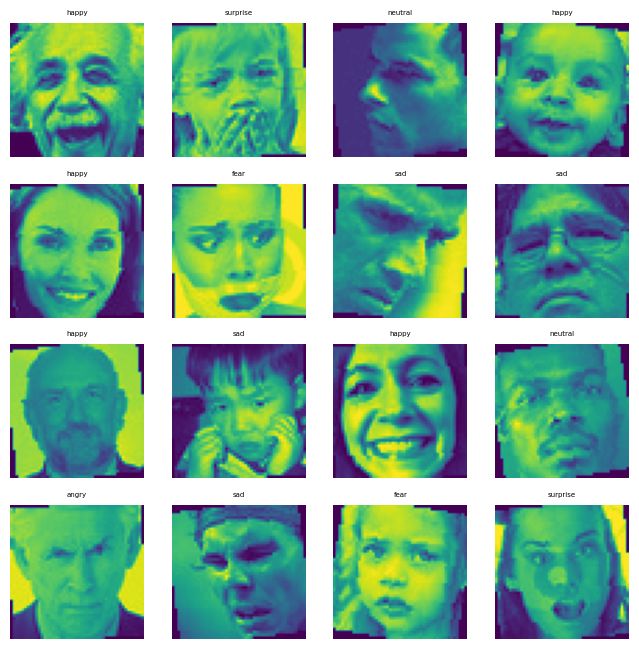

In [7]:
fig = plt.figure(figsize=(8,8))
rows, cols = 4,4
for i in range(1, rows * cols + 1):
    rand_idx = np.random.randint(0, len(train_dataset), size=1).item()
    img, label = train_dataset[rand_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze())
    plt.title(CLASS_NAMES[label],fontdict={'fontsize':5})
    plt.axis(False);

In [8]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()


train_dl = DataLoader(train_dataset, 
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      pin_memory=True,
                      num_workers=NUM_WORKERS)
val_dl = DataLoader(val_dataset,
                    batch_size=BATCH_SIZE,
                    shuffle=False,
                    pin_memory=True,
                    num_workers=NUM_WORKERS)
test_dl = DataLoader(test_dataset, 
                      batch_size=BATCH_SIZE,
                      shuffle=False,
                      pin_memory=True,
                      num_workers=NUM_WORKERS)

-- BUILD UP ARCHITECTURE --

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.downsample=None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample:
            residual = self.downsample(x)
            
        out += residual
        return self.relu(out)


class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=8):
        super(ChannelAttention, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, h, w = x.shape
        gap = x.mean(dim=[2,3])
        attention = self.fc(gap).view(b,c,1,1)
        return x * attention


class FERwithResidualAttention(nn.Module):
    def __init__(self, num_classes):
        super(FERwithResidualAttention, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block1 = ResidualBlock(32, 32)
        self.attn1 = ChannelAttention(32)
        
        self.block2 = ResidualBlock(32, 64, stride=2)
        self.attn2 = ChannelAttention(64)
        
        self.block3 = ResidualBlock(64, 128, stride=2)
        self.attn3 = ChannelAttention(128)
        
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.attn1(self.block1(x))
        x = self.attn2(self.block2(x))
        x = self.attn3(self.block3(x))
        x = self.gap(x)
        return self.fc(x.view(x.size(0), -1))

In [10]:
model = FERwithResidualAttention(len(CLASS_NAMES)).to(device)
# model

In [11]:
def train_step(model, dataloader, loss_fn, optimizer, device, use_mixup=False, mixup_alpha=0.8):
    model.train()
    train_loss, train_acc = 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        mixed_targets = None
        if use_mixup:
            X, mixed_targets = mix_up(X, y, mixup_alpha)
        
        optimizer.zero_grad()
        outputs = model(X)
        
        if use_mixup and mixed_targets is not None:
            loss = mixup_lossfn(outputs, mixed_targets, loss_fn)
        else:
            loss = loss_fn(outputs, y)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        y_preds = outputs.argmax(dim=1)
        train_acc += (y_preds == y).sum().item() / len(y_preds)
        
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

def val_step(model, dataloader, loss_fn, device):
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            val_loss += loss.item()
            y_preds = outputs.argmax(dim=1)
            val_acc += (y_preds == y).sum().item() / len(y_preds)

    val_loss /= len(dataloader)
    val_acc /= len(dataloader)
    return val_loss, val_acc

# Train step
def train(model, train_dl, val_dl, optimizer, loss_fn, epochs, device, scheduler=None, patience=5, save_path='best_model.pt'):

    results = {'train_loss': [], 'train_acc': [],
               'val_loss': [], 'val_acc': []}

    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        
        train_loss, train_acc = train_step(model, train_dl, loss_fn, optimizer, device)
            
        val_loss, val_acc = val_step(model, val_dl, loss_fn, device)

        # scheduler step
        if scheduler:
            scheduler.step()

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['val_loss'].append(val_loss)
        results['val_acc'].append(val_acc)

        print(
            f"Epoch {epoch+1:03}/{epochs:03} | "
            f"Loss: {train_loss:.4f} | Acc: {train_acc*100:.2f}% | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%"
        )
        # early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'val_loss': val_loss,
                'val_acc': val_acc,
                'train_loss': train_loss,
                'train_acc': train_acc,
            },save_path)
            
            print(f"Epoch {epoch+1}: New best val loss: {val_loss:.4f}")
            print(f"Checkpoint saved to {save_path}")
        else:
            patience_counter += 1
            print(f"Epoch {epoch}: No Improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break


    print(f"Training completed. Best mode saved to {save_path}")
        
    return results


In [12]:
lr = 5e-4
epochs = 30

optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr, weight_decay=0.01)
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr/100)

results = train(model, train_dl, val_dl, optimizer, loss_fn, epochs, device, scheduler)

Epoch 001/030 | Loss: 1.6092 | Acc: 35.92% | Val Loss: 1.4701 | Val Acc: 43.96%
Epoch 1: New best val loss: 1.4701
Checkpoint saved to best_model.pt
Epoch 002/030 | Loss: 1.3559 | Acc: 48.02% | Val Loss: 1.2941 | Val Acc: 50.52%
Epoch 2: New best val loss: 1.2941
Checkpoint saved to best_model.pt
Epoch 003/030 | Loss: 1.2600 | Acc: 52.10% | Val Loss: 1.2195 | Val Acc: 53.26%
Epoch 3: New best val loss: 1.2195
Checkpoint saved to best_model.pt
Epoch 004/030 | Loss: 1.2040 | Acc: 53.97% | Val Loss: 1.2413 | Val Acc: 52.81%
Epoch 3: No Improvement. Patience: 1/5
Epoch 005/030 | Loss: 1.1548 | Acc: 55.91% | Val Loss: 1.2042 | Val Acc: 53.97%
Epoch 5: New best val loss: 1.2042
Checkpoint saved to best_model.pt
Epoch 006/030 | Loss: 1.1240 | Acc: 57.37% | Val Loss: 1.1587 | Val Acc: 56.82%
Epoch 6: New best val loss: 1.1587
Checkpoint saved to best_model.pt
Epoch 007/030 | Loss: 1.0881 | Acc: 58.56% | Val Loss: 1.1111 | Val Acc: 57.50%
Epoch 7: New best val loss: 1.1111
Checkpoint saved to b

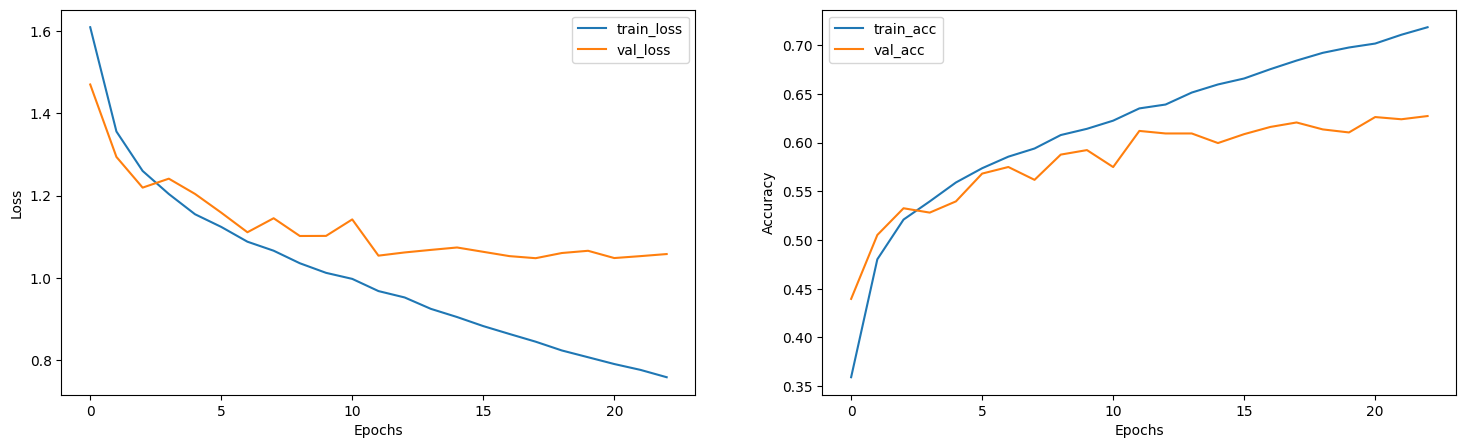

In [13]:
train_loss = results['train_loss']
train_acc = results['train_acc']
val_loss = results['val_loss']
val_acc = results['val_acc']

epochs_ = range(len(train_loss))
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plt.plot(epochs_, train_loss, label='train_loss')
plt.plot(epochs_, val_loss, label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_, train_acc, label='train_acc')
plt.plot(epochs_, val_acc, label='val_acc')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [14]:
# Evaluation on test dataset
def evaluation_step(model, test_dl, loss_fn, class_names, device):
    model.eval()
    test_loss, test_acc = 0, 0
    y_true, y_pred = [], []

    with torch.inference_mode():
        for X, y in test_dl:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            test_loss += loss.item()

            preds = outputs.argmax(dim=1)
            test_acc += (preds == y).sum().item() / len(preds)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    avg_loss = test_loss / len(test_dl)
    avg_acc = test_acc / len(test_dl)
    
    # tqdm.write(f"Test Loss: {avg_loss:.4f} | Test Acc: {avg_acc*100:.2f}% | Test F1: {test_f1:.4f}")
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show();

Loaded model from epoch 17
Checkpoint validation loss: 1.0480
Checkpoint validation accuracy: 62.07%
              precision    recall  f1-score   support

       angry       0.52      0.61      0.56       958
     disgust       0.51      0.27      0.35       111
        fear       0.49      0.32      0.39      1024
       happy       0.83      0.84      0.84      1774
     neutral       0.54      0.63      0.58      1233
         sad       0.48      0.47      0.48      1247
    surprise       0.73      0.78      0.75       831

    accuracy                           0.62      7178
   macro avg       0.59      0.56      0.56      7178
weighted avg       0.61      0.62      0.61      7178



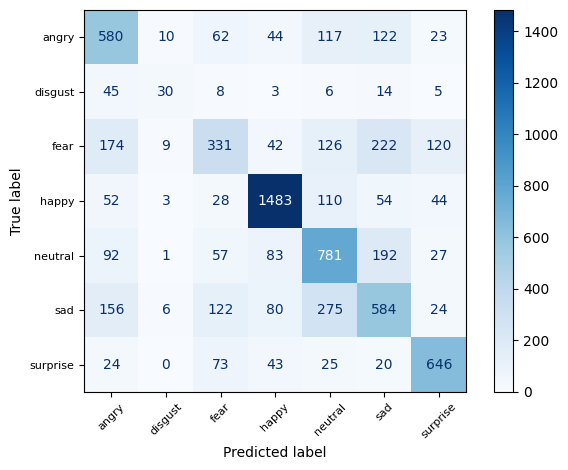

In [15]:
checkpoint = torch.load('best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

print(f"Loaded model from epoch {checkpoint['epoch']}")
print(f"Checkpoint validation loss: {checkpoint['val_loss']:.4f}")
print(f"Checkpoint validation accuracy: {checkpoint['val_acc']*100:.2f}%")

evaluation_step(model, test_dl, loss_fn, class_names=CLASS_NAMES, device=device)